In [8]:
import mesa
import numpy as np
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import pandas as pd
import matplotlib.pyplot as plt

Uncoordinate Agent

In [ ]:
class RandomAgent(mesa.Agent): # Implementation of M1 (uncoordinate)
    def __init__(self, model):
        super().__init__(model)
        self.movements = 0

    def step(self): # Step Agent Behavior
        x, y = self.pos
        if self.model.dirtyGrid[x][y] == 1:
            self.model.dirtyGrid[x][y] = 0
        else:
            neighbors = self.model.grid.get_neighborhood(
                pos=self.pos, moore=True, include_center=False
            )
            if neighbors:
                newPos = self.random.choice(neighbors)
                self.model.grid.move_agent(self, newPos)
                self.movements += 1

Coordinate Agent

In [ ]:
class CoordinatedAgent(mesa.Agent): # Model Definition (Coordinate)
    def __init__(self, model):
        super().__init__(model)
        self.movements = 0

    def step(self): # Step Behavior of a coordinate Agent
        x, y = self.pos
        if self.model.dirtyGrid[x][y] == 1:
            self.model.dirtyGrid[x][y] = 0
        else:
            neighbors = self.model.grid.get_neighborhood(
                pos=self.pos, moore=True, include_center=False
            )
            
            dirtyNeighbors = []
            for nPos in neighbors:
                nx, ny = nPos
                if self.model.dirtyGrid[nx][ny] == 1:
                    dirtyNeighbors.append(nPos)
            if dirtyNeighbors:
                newPos = self.random.choice(dirtyNeighbors)
            else:
                newPos = self.random.choice(neighbors)
                
            self.model.grid.move_agent(self, newPos)
            self.movements += 1

Model

In [ ]:
class CleaningModel(mesa.Model): # Definition of Model
    def __init__(self, m, n, numAgent, dirtyPercentage, maxTime, strategy="uncoordinated"):
        super().__init__()
        self.numAgent = numAgent
        self.maxRounds = maxTime
        self.steps = 0
        self.strategy = strategy
        
        self.grid = MultiGrid(m, n, torus=False)
        self.dirtyGrid = np.where(np.random.rand(m, n) < dirtyPercentage, 1, 0)
        
        for _ in range(self.numAgent): # Define depending of input straegy, which agent will be use
            if strategy == "coordinated":
                agent = CoordinatedAgent(self)
            else:
                agent = RandomAgent(self)
            
            self.grid.place_agent(agent, (1, 1))

        self.datacollector = DataCollector(
            model_reporters={"CleanedPct": lambda m: (1.0 - np.mean(m.dirtyGrid)) * 100},
            agent_reporters={"Movements": lambda a: a.movements}
        )

    def step(self):
        self.datacollector.collect(self)
        if self.steps >= self.maxRounds or (1.0 - np.mean(self.dirtyGrid)) == 1.0:
            self.running = False
        else:
            self.agents.shuffle_do("step")
            self.steps += 1

Comparisson

In [ ]:
def runExperiments(): # Data to run experiment
    m, n = 10, 10
    dirtyPct = 0.5
    maxTime = 100
    agentCounts = [3, 5, 10]
    
    results = []

    print(f"Grid: {m}x{n} | Dirty: {dirtyPct*100}% | Start Pos: (1,1) | Max Steps: {maxTime}")
    print("-" * 70)
    print(f"{'Strategy':<15} | {'Agents':<6} | {'Steps':<5} | {'Cleaned %':<10} | {'Total Moves':<10}")
    print("-" * 70)

    for nAgents in agentCounts: # Run with different number of agents
        for strategy in ["uncoordinated", "coordinated"]:
            model = CleaningModel(m, n, nAgents, dirtyPct, maxTime, strategy)
            model.run_model()
            
            final_steps = model.steps
            final_clean = (1.0 - np.mean(model.dirtyGrid)) * 100
            
            agent_data = model.datacollector.get_agent_vars_dataframe()
            try:
                last_step = agent_data.index.get_level_values('Step').max()
                total_moves = agent_data.xs(last_step, level="Step")["Movements"].sum()
            except:
                total_moves = 0

            print(f"{strategy:<15} | {nAgents:<6} | {final_steps:<5} | {final_clean:<10.2f} | {total_moves:<10}")
            
            results.append({
                "Strategy": strategy,
                "Agents": nAgents,
                "Steps": final_steps,
                "Cleaned": final_clean,
                "Moves": total_moves
            })
            
    return pd.DataFrame(results)

Execution

In [13]:
dfResults = runExperiments()

Grid: 10x10 | Dirty: 50.0% | Start Pos: (1,1) | Max Steps: 100
----------------------------------------------------------------------
Strategy        | Agents | Steps | Cleaned %  | Total Moves
----------------------------------------------------------------------
uncoordinated   | 3      | 101   | 73.00      | 131       
coordinated     | 3      | 101   | 92.00      | 106       
uncoordinated   | 5      | 101   | 93.00      | 210       
coordinated     | 5      | 71    | 100.00     | 133       
uncoordinated   | 10     | 101   | 92.00      | 464       
coordinated     | 10     | 65    | 100.00     | 268       


Visualization

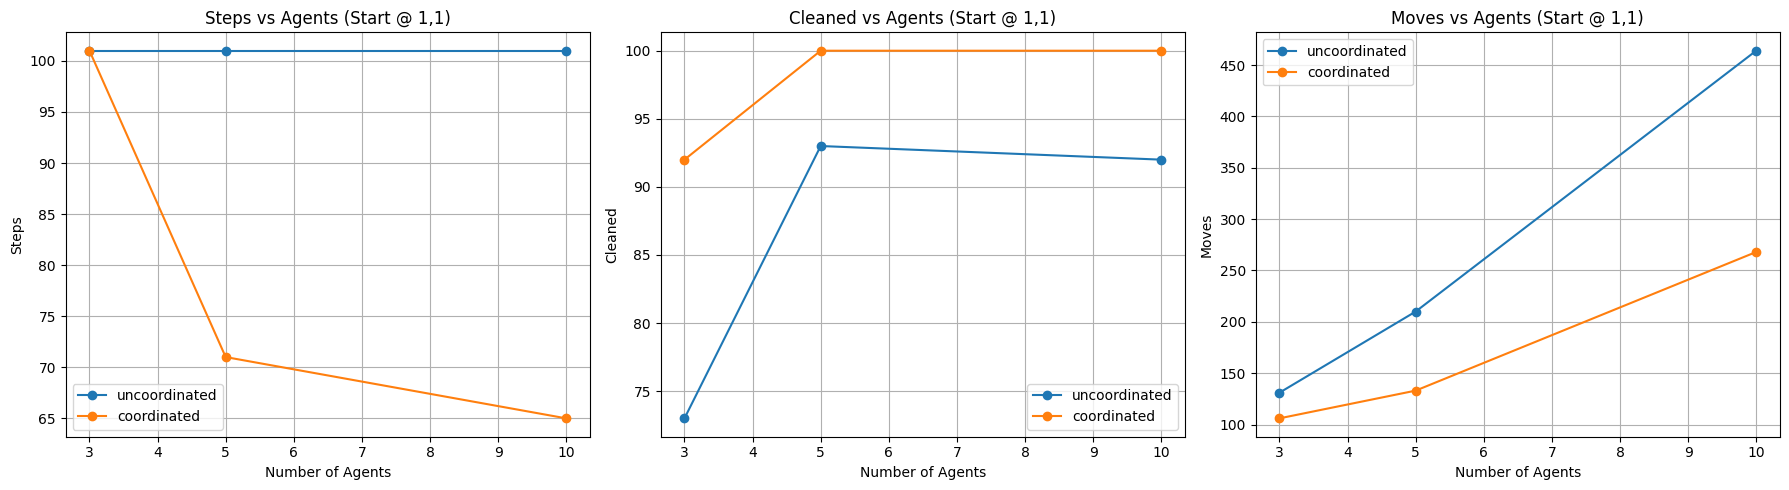

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['Steps', 'Cleaned', 'Moves']):
    ax = axes[i]
    for strategy in ["uncoordinated", "coordinated"]:
        subset = dfResults[dfResults['Strategy'] == strategy]
        ax.plot(subset['Agents'], subset[metric], marker='o', label=strategy)
    ax.set_title(f"{metric} vs Agents (Start @ 1,1)")
    ax.set_xlabel("Number of Agents")
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()